# 基于 numpy 了解 torch 自动微分系统

## 前言

torch 提供了一套自动微分系统。基于自动构建的 动态计算图，使用者能够非常方便的搭建人工神经网络。

本笔记从零开始基于 numpy 搭建一个简单的 MLP 层，实现简单的 分类 和 回归 任务。

## 动态计算图

我们构建一个简单的运算：

$c = a + b, e = c * d$

绘制成图可以表示为如下：

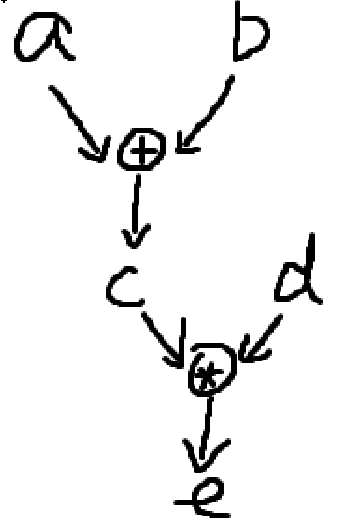

如果我们想要求 $\frac{\partial e}{\partial a}, \frac{\partial e}{\partial b}$，我们可以通过链式求导法则得到：

$\frac{\partial e}{\partial a}=\frac{\partial c}{\partial a}\frac{\partial e}{\partial c}, \frac{\partial e}{\partial b}=\frac{\partial c}{\partial b}\frac{\partial e}{\partial c}$

而其中 $\frac{\partial e}{\partial c} = \frac{\partial (c * d)}{\partial c} = d$，进而计算得 $\frac{\partial e}{\partial a}=d, \frac{\partial e}{\partial b}=d$，整个计算过程可以对应至下图中的红色箭头：

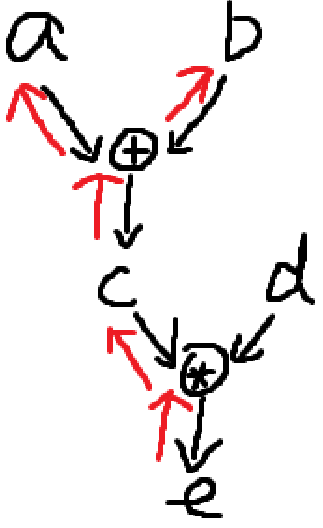

欸，不对呀，这只是标量，向量怎么办？？？

okk，先回顾标量对向量的梯度怎么表示的吧，下面的 $l \in \mathbb{R}, \mathbf{x}\in \mathbb{R}^d$：

$
\begin{aligned}
\frac{\partial l}{\partial \mathbf{x}} = \left[ \frac{\partial l}{\partial x_1} \; \frac{\partial l}{\partial x_2} \cdots \frac{\partial l}{\partial x_d} \right]^\top
\end{aligned}
$

实际上就是将 函数 对 向量的每个分量 求 偏导数。

矩阵也一样，本质上也是向量，下面的 $l \in \mathbb{R}, \mathbf{A}\in \mathbb{R}^{m\times n}$：

$
\begin{aligned}
\frac{\partial l}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial l}{\partial x_{11}} & \frac{\partial l}{\partial x_{1m}} & \cdots & \frac{\partial l}{\partial x_{1n}} \\
\frac{\partial l}{\partial x_{21}} & \frac{\partial l}{\partial x_{22}} & \cdots & \frac{\partial l}{\partial x_{2n}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial l}{\partial x_{m1}} & \frac{\partial l}{\partial x_{m2}} & \cdots & \frac{\partial l}{\partial x_{mn}} \\
\end{bmatrix}
\end{aligned}
$

卧槽，那这上面的 $\mathbf{c} = \mathbf{a} + \mathbf{b}, e = \mathbf{c}^\top \mathbf{d}$ 怎么算？

$\frac{\partial e}{\partial \mathbf{a}}$ 本质上就是对 $\mathbf{a}$ 的每一个分量计算偏导数，显然我们可以继续使用上面的计算图。

$\frac{\partial e}{\partial a_i} = \sum_j \frac{\partial c_j}{\partial a_i} \frac{\partial e}{\partial c_j} = \left[\frac{\partial c_1}{\partial a_i}\cdots \frac{\partial c_d}{\partial a_i}\right] \frac{\partial e}{\partial \mathbf{c}}$

实际上就是先计算 $\frac{\partial e}{\partial c_j}$ 再计算 $\frac{\partial c_j}{\partial a_i}$，再对 $j$ 求和。

别急，我们先整理整理 $\frac{\partial e}{\partial a_i}$:

$$
\begin{aligned}
\frac{\partial e}{\partial \mathbf{a}} = 
\begin{bmatrix}
\left[\frac{\partial c_1}{\partial a_1}\cdots \frac{\partial c_d}{\partial a_1}\right] \frac{\partial e}{\partial \mathbf{c}} \\
\left[\frac{\partial c_1}{\partial a_2}\cdots \frac{\partial c_d}{\partial a_2}\right] \frac{\partial e}{\partial \mathbf{c}} \\
\vdots \\
\left[\frac{\partial c_1}{\partial a_s}\cdots \frac{\partial c_d}{\partial a_s}\right] \frac{\partial e}{\partial \mathbf{c}} \\
\end{bmatrix}
= 
\begin{bmatrix}
\frac{\partial c_1}{\partial a_1} & \frac{\partial c_2}{\partial a_1} & \cdots & \frac{\partial c_d}{\partial a_1}  \\
\frac{\partial c_1}{\partial a_2} & \frac{\partial c_2}{\partial a_2} & \cdots & \frac{\partial c_d}{\partial a_2}  \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial c_1}{\partial a_s} & \frac{\partial c_2}{\partial a_s} & \cdots & \frac{\partial c_d}{\partial a_s}  \\
\end{bmatrix} \frac{\partial e}{\partial \mathbf{c}}
\\
=
\begin{bmatrix}
\frac{\partial c_1}{\partial a_1} & \frac{\partial c_2}{\partial a_1} & \cdots & \frac{\partial c_d}{\partial a_1}  \\
\frac{\partial c_1}{\partial a_2} & \frac{\partial c_2}{\partial a_2} & \cdots & \frac{\partial c_d}{\partial a_2}  \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial c_1}{\partial a_s} & \frac{\partial c_2}{\partial a_s} & \cdots & \frac{\partial c_d}{\partial a_s}  \\
\end{bmatrix}
\begin{bmatrix}
\frac{\partial e}{\partial c_{1}} \\
\frac{\partial e}{\partial c_{2}} \\
\vdots \\
\frac{\partial e}{\partial c_{d}} \\
\end{bmatrix}
=
\left[\frac{\partial c_1}{\partial \mathbf{a}} \frac{\partial c_2}{\partial \mathbf{a}} \cdots \frac{\partial c_d}{\partial \mathbf{a}}\right]\frac{\partial e}{\partial \mathbf{c}}
=\mathbf{J}\frac{\partial e}{\partial \mathbf{c}}
\end{aligned}
$$

其中的 $\mathbf{J}$ 称之为 $\mathbf{c}$ 对 $\mathbf{a}$ 的 雅可比矩阵。

也就是说，我们可以先计算 $\frac{\partial e}{\partial \mathbf{c}}$，接着计算 $\mathbf{c}$ 对 $\mathbf{a}$ 的 雅可比矩阵 $\mathbf{J}$，那么 $\frac{\partial e}{\partial \mathbf{a}} = \mathbf{J} \frac{\partial e}{\partial \mathbf{c}}$。

在上面的 $\mathbf{c} = \mathbf{a} + \mathbf{b}$中，$\mathbf{J}_\mathbf{a}^\mathbf{c} = \mathbf{J}_\mathbf{b}^\mathbf{c} = \mathbf{I}$。

按照这种思路，无论计算过程多复杂，只需先计算 $\frac{\partial y}{\partial \mathbf{x}_i}$，接着计算 $\mathbf{J}_{\mathbf{x}_{i-1}}^{\mathbf{x}_{i}}$，则有 $\frac{\partial y}{\partial \mathbf{x}_{i-1}} = \mathbf{J}_{\mathbf{x}_{i-1}}^{\mathbf{x}_{i}} \frac{\partial y}{\partial \mathbf{x}_i}$。

链式法则不就出来了么，一次次的求解雅可比矩阵就可以了：

$\frac{\partial y}{\partial \mathbf{x}_{i}} = \mathbf{J}_{\mathbf{x}_{i}}^{\mathbf{x}_{i+1}}\mathbf{J}_{\mathbf{x}_{i+1}}^{\mathbf{x}_{i+2}} \cdots \mathbf{J}_{\mathbf{x}_{n-1}}^{\mathbf{x}_{n}} \frac{\partial y}{\partial \mathbf{x}_n}$

问：中间结果是矩阵怎么办，或者参与运算的就是矩阵呢？首先一种方式是把矩阵拉成向量（实际上不是很管用），另一种方式是先将矩阵按照行（目标是左乘时）或者列分析（目标是右乘时），分别计算对应每行或者列的雅可比矩阵，然后根据矩阵的性质，推导总体结果，或者拼凑总体结果。 

说这么多，我们怎么用代码实现呢？

实际上，torch 在进行运算时（假设需要求梯度），每一次运算都会构建一个对象，在给定目标对输出的梯度时，计算目标对输入的梯度，也就是实现上面提到的 雅可比矩阵 的功能（实际实现不一定是通过计算雅可比矩阵-向量积 jpv）。同时，将所有梯度计算对象按照计算目标的过程组织成计算图，这时候只需遍历整个计算图，即可完成梯度计算。

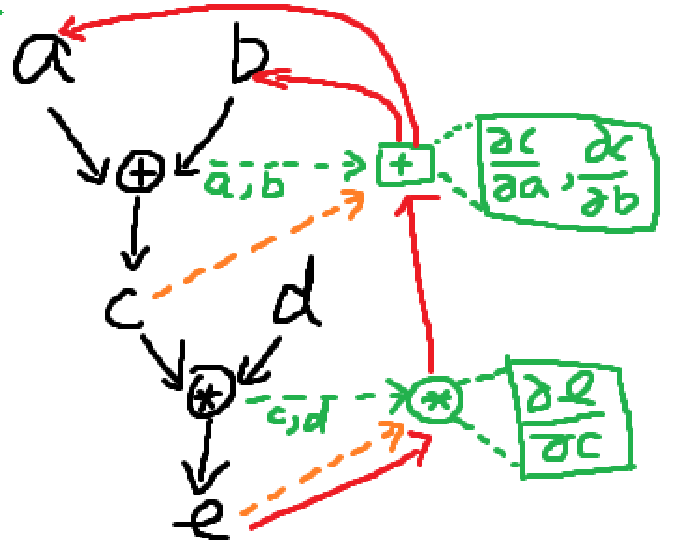
 

## 拓展 numpy.ndarray

显然原有的 numpy.ndarray 没办法满足我们的需求，我们需要额外的 4 个属性，grad: 记录梯度结果，grad_fn，记录生成该矩阵、向量、或者标量的操作对应的梯度计算对象，requires_grad: 是否需要计算梯度，is_leaf: 是否是叶子节点，只有叶子节点的梯度会被记录。

拓展 numpy.ndarray 一种方式是子类化，但是这需要对 numpy 具有非常深入的了解，不推荐。我们打算使用一个类将 numpy 包装起来，然后 实现其 __array__ 方法，以此来支持 numpy 的其他操作。这将要求我们在计算过程中持续关注计算图构建的过程。

In [1]:
import numpy as np
from typing import List, Dict, Tuple, Union, Optional, Iterable
import copy

def auto_grad(start_fn, grad_input):
    pass

def mul(input_int: Iterable[int]):
    ret = 1
    for int_ in input_int:
        ret *= int_

    return ret

class GArray:
    _data: np.ndarray
    is_leaf: Union[None, bool]
    requires_grad: Union[None, bool]
    grad: Union[np.ndarray, None]
    grad_fn: Union[object, None]
    
    def __init__(self, data: np.ndarray, *create_from):
        self._data = data
        self.grad = None
        # which function the array is calculated from and index of the output position
        self.grad_fn = (None, 0)
        self.is_leaf = None
        self.requires_grad = None
        self.calibrate(*create_from)
            
    def calibrate(self, *create_from):
        if create_from is not None and len(create_from) == 0:
            self.is_leaf = True
            self.requires_grad = True
        else:
            self.is_leaf = False  # not any(getattr(arg, "is_leaf", True) for arg in create_from)
            self.requires_grad = any(getattr(arg, "requires_grad", False) for arg in create_from)
            
    def __array__(self):
        return self._data
    
    def __repr__(self):
        the_repr = f"GArray(\n{str(self._data)}"
        if self.requires_grad:
            the_repr += f", requires_grad={self.requires_grad}"
        if self.grad_fn is not None and self.grad_fn[0]:
            the_repr += f", grad_fn={self.grad_fn}"
            
        the_repr += ")"
        
        return the_repr
    
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, value):
        self._data = value
        
    def backward(self, retain_graph=False):
        assert mul(self.shape) == 1, "only scale is supported"
        assert self.grad_fn is not None and self.grad_fn[0] is not None, "no grad is calculated"
        start_fn = self.grad_fn[0]
        if not retain_graph:
            self.grad_fn = (None, 0)
        auto_grad(start_fn, 1.0, retain_graph)
        
    @property
    def shape(self):
        return np.shape(self._data)

In [2]:
a = np.random.randn(2, 3)
b = GArray(a)
c = np.random.randn(2, 3)
d = np.add(b, c)
e = GArray(d, b, c)
print("{}\n{}\n{}\n{}\n{}".format(a, b, c, d, e))

[[-1.34140354 -0.60761294 -0.57684315]
 [-1.12732111  1.13524931 -0.14487951]]
GArray(
[[-1.34140354 -0.60761294 -0.57684315]
 [-1.12732111  1.13524931 -0.14487951]], requires_grad=True)
[[-1.09491303  0.04984123 -0.31763771]
 [ 0.04303438 -0.76050632 -0.33439211]]
[[-2.43631657 -0.55777171 -0.89448087]
 [-1.08428673  0.37474299 -0.47927163]]
GArray(
[[-2.43631657 -0.55777171 -0.89448087]
 [-1.08428673  0.37474299 -0.47927163]], requires_grad=True)


## 构建计算图

ok，现在基于这个类，我们希望实现一个半自动构建计算图的自动微分系统。也就是每次我们调用 操作函数 进行运算，能够自动创建 求梯度对象，并且能够正确的对计算结果的 grad_fn 赋值。

In [3]:
class GradFunction:
    def __init__(self):
        self.ctx = None
        # a list of function, corresponding to each operand is calculated from and the index of them when being output
        self.next_fns = None
        self.num_grad_inputs = 1  # defaults value
        
        # for garbage collection, we must record who has reference pointed to this obj
        self.be_pointed = None
        
    def add_be_pointed(self, obj):
        # only be pointed by GArray or GradFunction, but we only process instances of GArray, 
        # instances of GradFunction will be processed by auto_grad
        if isinstance(obj, GArray):
            if self.be_pointed is None:
                self.be_pointed = [obj]
            else:
                self.be_pointed.append(obj)
    
    def release_ref(self):
        if self.be_pointed is not None:
            for obj in self.be_pointed:
                obj.grad_fn = (None, 0)
        
    def forward(self, *args):
        # only support the positional argument call
        raise NotImplementedError
        
    def backward(self, *args):
        # only support the positional argument call
        raise NotImplementedError
        
    @staticmethod
    def wrap_results(results, create_from):
        new_results = []
        for rst in results:
            if isinstance(rst, np.ndarray):
                new_rst = GArray(rst, *create_from)
            elif isinstance(rst, GArray):
                rst.calibrate(*create_from)
                new_rst = rst
            else:
                new_rst = rst
            new_results.append(new_rst)
            
        return new_results
        
    @classmethod
    def apply(cls, *args):
        func = cls()
        requires_grad = any(getattr(opnd, "requires_grad", False) for opnd in args)
        if requires_grad:
            next_fn_list = []
            for opnd in args:
                is_leaf = getattr(opnd, "is_leaf", False)
                requires_grad = getattr(opnd, "requires_grad", False)
                if not is_leaf:
                    # if is not a leaf, pass the grad_fn
                    next_grad_fn = getattr(opnd, "grad_fn", (None, 0))
                else:
                    # if the opnd is a leaf node, we prepend a AccumulateGrad object to pass the grad to the opnd
                    next_grad_fn = (AccumulateGrad(opnd), 0) if requires_grad else (None, 0)
                next_fn_list.append(next_grad_fn)
            
            # set the previous gradient functions
            func.next_fns = next_fn_list
                
            results = func.forward(*args)
            
            if not isinstance(results, tuple):
                results = (results, )
            
            # wrap the results with GArray
            results = func.wrap_results(results, args)
            
            for idx, rst in enumerate(results):
                if isinstance(rst, GArray) and not rst.is_leaf:
                    grad_fn = (func, idx)
                    rst.grad_fn = grad_fn
                    
                    # we maintain this for garbage collection, if we need release the grad, we must del the reference in GArrays
                    func.add_be_pointed(rst)
            
            return results if len(results) > 1 else results[0]
        else:
            return func.forward(*args)

        
class AccumulateGrad(GradFunction):
    def __init__(self, target):
        super().__init__()
        self.target = target
        
    def forward(self, *args):
        pass

    def backward(self, input_grad):
        if hasattr(self.target, "grad"):
            if self.target.grad is None:
                self.target.grad = copy.deepcopy(input_grad)
            else:
                self.target.grad += input_grad

上面的 GradFunction 和 AccumulateGrad，分别实现了我们所需要的基类，以及最简单的累加梯度。

回顾上面的例子，$\mathbf{c} = \mathbf{a} + \mathbf{b}, e = \mathbf{c}^\top \mathbf{d}$，我们需要实现一个加法，一个向量点乘的操作。

In [4]:
class ColumnVectorAdd(GradFunction):
    def forward(self, a, b):
        # Column vector
        assert len(np.shape(a)) == 2 \
                and len(np.shape(b)) == 2 \
                and np.shape(a)[1] == 1 \
                and np.shape(b)[1] == 1 \
                and np.shape(a)[0] == np.shape(b)[0], \
                f"expect two column vector with the same shape, but get {np.shape(a)} and {np.shape(b)}"
        self.ctx = (a, b)  # record for calculate the gradient
        result = np.add(a, b)
        
        return result
    
    def backward(self, input_grad):
        # input_grad: [m ,1]
        a, b = self.ctx
        grad_a = copy.deepcopy(input_grad)
        grad_b = copy.deepcopy(input_grad)
        return grad_a, grad_b
    

class ColumnVectorDotProduct(GradFunction):
    def forward(self, a, b):
        # Column vector
        assert len(np.shape(a)) == 2 \
                and len(np.shape(b)) == 2 \
                and np.shape(a)[1] == 1 \
                and np.shape(b)[1] == 1 \
                and np.shape(a)[0] == np.shape(b)[0], \
                f"expect two column vector with the same shape, but get {np.shape(a)} and {np.shape(b)}"
        self.ctx = (a, b)  # record for calculate the gradient
        result = np.matmul(np.transpose(a), b)
        
        return result
    
    def backward(self, grad_input):
        # grad_input: [1, 1]
        a, b = self.ctx
        grad_a = np.multiply(b, grad_input)
        grad_b = np.multiply(a, grad_input)
        return grad_a, grad_b

构建计算过程

In [5]:
a = GArray(np.random.randn(3, 1))
b = GArray(np.random.randn(3, 1))
c = ColumnVectorAdd.apply(a, b)
d = np.random.randn(3, 1)
e = ColumnVectorDotProduct.apply(c, d)

检查计算结果

In [6]:
print(a, "\n", b, "\n", c, "\n", d, "\n", e)
print(id(a), id(b), id(c), id(d), id(e))

GArray(
[[ 0.47155645]
 [-0.13052102]
 [-1.16814819]], requires_grad=True) 
 GArray(
[[-1.54086403]
 [-1.25349468]
 [-1.90788302]], requires_grad=True) 
 GArray(
[[-1.06930758]
 [-1.3840157 ]
 [-3.07603121]], requires_grad=True, grad_fn=(<__main__.ColumnVectorAdd object at 0x0000021AC2F02B80>, 0)) 
 [[ 0.27657126]
 [-0.3394748 ]
 [-0.56643859]] 
 GArray(
[[1.91648149]], requires_grad=True, grad_fn=(<__main__.ColumnVectorDotProduct object at 0x0000021AC2F02F70>, 0))
2313962923296 2313962925696 2313962924208 2314487390928 2313962923968


检查计算图

In [7]:
print(e.grad_fn)
print(e.grad_fn[0].next_fns)
print(e.grad_fn[0].next_fns[0])
print(e.grad_fn[0].next_fns[0][0].next_fns)
print(e.grad_fn[0].next_fns[0][0].next_fns[0][0].target is a)
print(e.grad_fn[0].next_fns[0][0].next_fns[1][0].target is b)
id_1 = id(e.grad_fn[0])
id_2 = id(e.grad_fn[0].next_fns[0][0])
id_3 = id(e.grad_fn[0].next_fns[0][0].next_fns[0][0])
id_4 = id(e.grad_fn[0].next_fns[0][0].next_fns[1][0])

(<__main__.ColumnVectorDotProduct object at 0x0000021AC2F02F70>, 0)
[(<__main__.ColumnVectorAdd object at 0x0000021AC2F02B80>, 0), (None, 0)]
(<__main__.ColumnVectorAdd object at 0x0000021AC2F02B80>, 0)
[(<__main__.AccumulateGrad object at 0x0000021AC2F02190>, 0), (<__main__.AccumulateGrad object at 0x0000021AC2F02910>, 0)]
True
True


回传计算梯度

In [8]:
e2c, e2d = e.grad_fn[0].backward([[1]])

In [9]:
e2a, e2b = e.grad_fn[0].next_fns[0][0].backward(e2c)

In [10]:
e.grad_fn[0].next_fns[0][0].next_fns[0][0].backward(e2a)
e.grad_fn[0].next_fns[0][0].next_fns[1][0].backward(e2b)

In [11]:
a.grad

array([[ 0.27657126],
       [-0.3394748 ],
       [-0.56643859]])

In [12]:
b.grad

array([[ 0.27657126],
       [-0.3394748 ],
       [-0.56643859]])

按照我们前面的推导，$\mathbf{a}, \mathbf{b}$ 的梯度值都为 $\mathbf{d}$

In [13]:
d

array([[ 0.27657126],
       [-0.3394748 ],
       [-0.56643859]])

结果符合

有几点可以注意：
- 我们实现 backward 函数的时候并没有计算 雅可比行列式，而是直接计算梯度，这是可以的，只需要保证梯度正确即可，不论计算方式如何。
- 计算梯度最后需要通过 AccumulateGrad 将具体的梯度值传递给我们想要计算梯度的 变量。

不过仔细一看，不对呀，手动回传也太麻烦了吧。

遍历图么，这还不简单，广度优先算法遍历整个图就好了。

In [14]:
# 节点
class Node:
    def __init__(self, grad_fn: GradFunction, grad_inputs: List):
        self.grad_fn = grad_fn
        self.grad_inputs = grad_inputs
    
    def calculate_grad(self):
        return self.grad_fn.backward(*self.grad_inputs)


# 队列
class CustomQueue:
    def __init__(self):
        self._data: List[Node] = []

    def put(self, data: Node):
        self._data.append(data)

    def get(self):
        data = self._data[0]
        del self._data[0]
        return data

    def check_in(self, data: Union[Node, GradFunction]):
        for item in self._data:
            if isinstance(data, GradFunction):
                if data is item.grad_fn:
                    return item
            else:
                if data.grad_fn is item.grad_fn:
                    return item

        return None

    def empty(self):
        return len(self._data) == 0
    
    def has_unary(self):
        return any(len(node.grad_inputs) <= 1 for node in self._data)
    
def auto_grad(start_fn: GradFunction, grad_input=None, retain_graph=False):
    assert start_fn is not None, "no gradient is calculated"
    grad_queue = CustomQueue()
    start_node = Node(start_fn, [grad_input])
    grad_queue.put(start_node)
    while not grad_queue.empty():
        current_node = grad_queue.get()
        grad_fn = current_node.grad_fn
        
        if grad_fn is None:
            continue
        
        # 解除由 GArray 出发的引用
        if not retain_graph:
            grad_fn.release_ref()
            
        args = current_node.grad_inputs
        get_ready = all(arg is not None for arg in args)
        if get_ready:
            if len(args) > 1 and not grad_queue.has_unary():
                # 笨办法，等待所有一元节点结束
                grad_queue.put(current_node)
                continue
            output_grads = current_node.calculate_grad()
            # 实际上最好所有 function 计算梯度返回值都为 tuple，即便元素只有一个
            if not isinstance(output_grads, tuple):
                output_grads = (output_grads, )
                
            next_fns_list = grad_fn.next_fns
            if next_fns_list is None:
                continue
            for grad, (next_fn, idx) in zip(output_grads, next_fns_list):
                if next_fn is None:
                    continue 
                tmp_node = grad_queue.check_in(next_fn)
                if tmp_node is not None:
                    # 梯度在函数处累积，如果是输入梯度只有一个，那可以正确执行，因为累积后算梯度和算梯度后累积等价
                    # 但如果是多元梯度输入，需要等待所有前置节点计算梯度完成
                    tmp_node.grad_inputs[idx] = tmp_node.grad_inputs[idx] + grad if tmp_node.grad_inputs[idx] is not None else grad
                else:
                    next_grad_inputs = [None for _ in range(next_fn.num_grad_inputs)]
                    next_grad_inputs[idx] = grad
                    grad_queue.put(Node(next_fn, next_grad_inputs))
        else:
            grad_queue.put(current_node)

In [15]:
import gc
def ckeck_deleted(address):
    return not any(id(obj) == address for obj in gc.get_objects())

class A():
    pass

t = A()
address = id(t)
print(ckeck_deleted(address))
t = None
print(ckeck_deleted(address))

False
False


In [16]:
a.grad, b.grad = None, None

In [17]:
print(ckeck_deleted(id_1))
print(ckeck_deleted(id_2))
print(ckeck_deleted(id_3))
print(ckeck_deleted(id_4))

False
False
False
False


In [18]:
auto_grad(e.grad_fn[0], np.array([[1]]), True)

In [19]:
a.grad, b.grad, d

(array([[ 0.27657126],
        [-0.3394748 ],
        [-0.56643859]]),
 array([[ 0.27657126],
        [-0.3394748 ],
        [-0.56643859]]),
 array([[ 0.27657126],
        [-0.3394748 ],
        [-0.56643859]]))

In [20]:
auto_grad(e.grad_fn[0], np.array([[1]]))

In [21]:
a.grad, b.grad, d

(array([[ 0.55314253],
        [-0.67894961],
        [-1.13287718]]),
 array([[ 0.55314253],
        [-0.67894961],
        [-1.13287718]]),
 array([[ 0.27657126],
        [-0.3394748 ],
        [-0.56643859]]))

In [22]:
# 等待一段时间再运行，给垃圾回收一点时间
print(ckeck_deleted(id_1))
print(ckeck_deleted(id_2))
print(ckeck_deleted(id_3))
print(ckeck_deleted(id_4))
print(ckeck_deleted(address))

True
True
True
True
False


从上面来看，我们算是构建起了一个可以自动求 列向量加法，列向量内积 的自动求导系统，同时我们只需要对我们需要的操作实现对应的 GradFunction 的子类，并且通过 SubClass.apply(*args) 即可自动构建计算图。同时，auto_grad(e.grad_fn[0], np.array([[1]])) 这种调用方法不太方便，我们将其构建成 GArray 的 backward 方法。 

In [23]:
a = GArray(np.random.randn(3, 1))
b = GArray(np.random.randn(3, 1))
c = ColumnVectorAdd.apply(a, b)
d = np.random.randn(3, 1)
e = ColumnVectorDotProduct.apply(c, d)
e.backward()
a.grad, b.grad, d

(array([[ 1.08106764],
        [-0.2956713 ],
        [-0.78770587]]),
 array([[ 1.08106764],
        [-0.2956713 ],
        [-0.78770587]]),
 array([[ 1.08106764],
        [-0.2956713 ],
        [-0.78770587]]))

In [24]:
# 等待一段时间再运行，给垃圾回收一点时间
print(ckeck_deleted(id_1))
print(ckeck_deleted(id_2))
print(ckeck_deleted(id_3))
print(ckeck_deleted(id_4))
print(ckeck_deleted(address))

True
True
True
True
True


# Linear Layer

线性层的功能是通过线性映射将特征投影至其他空间，简单来说就是 $\mathbf{f'} = \mathbf{A}\mathbf{f}+\mathbf{b}$, 其中 $\mathbf{A} \in \mathbb{R}^{m\times n}, \mathbf{f} \in \mathbb{R}^{n\times 1}, \mathbf{f'}, \mathbf{b} \in \mathbb{R}^{m\times 1}$

简单推导可得：$\frac{\partial \ell}{\partial \mathbf{f}} = \mathbf{A}^\top\frac{\partial \ell}{\partial \mathbf{f'}}, \frac{\partial \ell}{\partial \mathbf{b}} = \frac{\partial \ell}{\partial \mathbf{f'}}, \frac{\partial \ell}{\partial \mathbf{A}}= \frac{\partial \ell}{\partial \mathbf{f'}} f^\top$

但是，实际上我们一般都是对一个batch的数据同时操作，即 

$\mathbf{F'} = \mathbf{F} \mathbf{A} + \mathbf{b}$

其中 $\mathbf{F} \in \mathbb{R}^{b\times d_{in}}, \mathbf{A} \in \mathbb{R}^{d_{in}\times d_{out}}, \mathbf{F'} \in \mathbb{R}^{b\times d_{out}}, \mathbf{b} \in \mathbb{R}^{1\times d_{out}}$，每一行代表一个特征。

首先看看 $\frac{\partial \ell}{\partial \mathbf{F}}$, 左乘按行分析：
$\mathbf{F'}_{j*} = \mathbf{F}_{j*} \mathbf{A} + \mathbf{b}_{1*}$

不难得知 $\frac{\partial \ell}{\partial \mathbf{F}_{j*}} = \frac{\partial \ell}{\partial \mathbf{F'}_{j*}} \mathbf{A}^\top$ 

此时按照矩阵乘法，将每一行组织起来，则有：$\frac{\partial \ell}{\partial \mathbf{F}} = \frac{\partial \ell}{\partial \mathbf{F'}} \mathbf{A}^\top$ 

再看看看 $\frac{\partial \ell}{\partial \mathbf{A}}$, 右乘按列分析：
$\mathbf{F'}_{*i} = \mathbf{F} \mathbf{A}_{*i} + \mathbf{b}_{1i}$

不难得知 $\frac{\partial \ell}{\partial \mathbf{A}_{*i}} =  \mathbf{F}^\top \frac{\partial \ell}{\partial \mathbf{F'}_{*i}}$ 

此时按照矩阵乘法，将每一列组织起来，则有A: $\frac{\partial \ell}{\partial \mathbf{A}} =  \mathbf{F}^\top \frac{\partial \ell}{\partial \mathbf{F'}}$ 

再来看看 $\frac{\partial \ell}{\partial \mathbf{b}}$

从这个式子中 $\mathbf{F'}_{j*} = \mathbf{F}_{j*} \mathbf{A} + \mathbf{b}_{1*}$ 得知 $\frac{\partial \ell}{\partial \mathbf{b}_{1*}} = \frac{\partial \ell}{\partial \mathbf{F'}_{j*}}$，其中 $\mathbf{b}_{1*} = \mathbf{b}$。

由于总共有 $b$ 行（batch size），所以 $\frac{\partial \ell}{\partial \mathbf{b}} = \sum_{j=1}^{b}\frac{\partial \ell}{\partial \mathbf{F'}_{j*}} = \mathbb{l}_{b}\frac{\partial \ell}{\partial \mathbf{F'}}$ (按行求和）


In [25]:
class LinearFunc(GradFunction):
    def forward(self, feature, weight, bias=None):
        # feature: [B, d_in], weight: [d_in, d_out], bias: [1, d_out]
        self.ctx = (feature, weight, bias)
        result = np.matmul(feature, weight)
        if bias is not None:
            result = np.add(result, bias)
        
        return result
    
    def backward(self, grad_input):
        feature, weight, bias = self.ctx
        grad_feature = np.matmul(grad_input, np.transpose(weight))
        grad_weight = np.matmul(np.transpose(feature), grad_input)
        grad_bias = np.sum(grad_input, axis=0, keepdims=True) if bias is not None else None
        return grad_feature, grad_weight, grad_bias

## ReLU Layer 激活层

ReLU 非线性激活层作用是将小于 0 的值变成 0，其余值原样输出。
非常简单，梯度回传时，非 0 位置梯度保持不变，小于 0 位置为 0。

In [26]:
class ReLUFunc(GradFunction):
    def forward(self, input_x):
        nparray_input_x = np.asarray(input_x)
        mask = nparray_input_x < 0
        self.ctx = (mask, )
        result = copy.deepcopy(nparray_input_x)
        result[mask] = 0
        return result
    
    def backward(self, grad_input):
        mask, = self.ctx
        grad_out = copy.deepcopy(grad_input)
        grad_out[mask] = 0
        return grad_out,

## MSE Loss Function

$l = \frac{1}{b}\sum_{i=1}^b (y - \hat{y})^2$

In [27]:
class MSELossFunc(GradFunction):
    def forward(self, input_x, target):
        # input_x: [b, 1], target: [b, 1]
        self.ctx = (input_x, target)
        results = np.mean((input_x - target) ** 2, keepdims=True)
        return results

    def backward(self, input_grad):
        input_x, target = self.ctx
        b, _ = np.shape(input_x)
        return 2 * np.subtract(input_x, target) * input_grad / b, 2 * np.subtract(target, input_x) * input_grad / b

## 计算图释放问题

python 自带 Garbage Collection 机制，只要对象的引用归零，该对象则进入垃圾回收的序列。

而在上面的例子中最为关键的是 GradFunction 的释放。

因此我们在 GArray, auto_grad，GradFunction 中添加了对应部分来解决 GArray 对象 对 GradFunction 对象的引用释放的问题。只要这部分引用释放，在此时便只有 auto_grad 中的队列内部存在对 GradFunction 的引用。一旦梯度计算完成退出 auto_grad 函数，所有引用都得到释放，计算图进入垃圾回收序列。

## 回归问题

基于上面的自动微分系统，我们已经能够基于 MLP 解决一些简单的回归问题了.

我们先构建一个简单的 SGD 优化器：

$\theta_{i+1} = \theta_{i} - \eta\triangledown \ell $

In [28]:
class SGD:
    def __init__(self, param_list: List[GArray], lr):
        assert self.check_params(param_list), "all params should be instance of GArray!"
        self.param_list = list(param_list)
        self.lr = lr
    
    @staticmethod
    def check_params(param_list: List[GArray]):
        return all(isinstance(p, GArray) for p in param_list)
    
    def zero_grad(self):
        for p in self.param_list:
            p.grad = None
    
    def step(self):
        for p in self.param_list:
            if p.grad is not None:
                p.data = p.data - self.lr * p.grad

我们简单的构建一个数据集：$y = 0.5x + 0.6 + \epsilon$

In [29]:
threshold  = 0.1
k = 0.5
b = 0.6
total_samples = 1000
x = np.random.random((total_samples, 1))
epsilon = np.random.randn(total_samples, 1)
mask = np.abs(epsilon) < threshold
# sign = np.sign(epsilon)
# epsilon[mask] = sign[mask] * threshold
x = x[mask]
epsilon = epsilon[mask]
y = k * x + b + epsilon
x = x[:, np.newaxis]
y = y[:, np.newaxis]
left_samples = x.shape[0]

(77, 1) (77, 1)


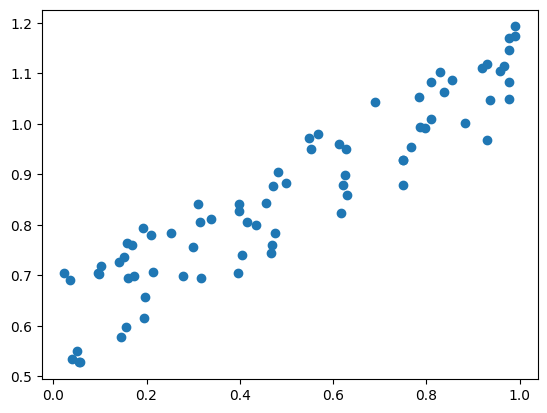

In [30]:
from matplotlib import pyplot as plt
print(x.shape, y.shape)
plt.scatter(x, y)

In [31]:
class Module:
    def __init__(self):
        self.param_list = []
        
    def call_implementation(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
        
    __call__ = call_implementation
    
    def requires_grad(self, req=True):
        for p in self.param_list:
            if isinstance(p, GArray):
                p.requires_grad = req
        

class LinearLayer(Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        weight = np.random.randn(in_dim, out_dim) * 0.1
        bias = np.random.randn(1, out_dim) * 0.1
        self.weight = GArray(weight)
        self.bias = GArray(bias)
        self.param_list.extend([self.weight, self.bias])
    
    def forward(self, input_x):
        return LinearFunc.apply(input_x, self.weight, self.bias)
    

class ReLU(Module):
    def forward(self, input_x):
        return ReLUFunc.apply(input_x)
    
class MSELoss(Module):
    def forward(self, input_x, target):
        return MSELossFunc.apply(input_x, target)

class MLP(Module):
    def __init__(self, in_dim, out_dim, hidden_dim=8):
        super().__init__()
        self.layer_1 = LinearLayer(in_dim, hidden_dim)
        self.param_list.extend(self.layer_1.param_list)
        self.relu = ReLU()
        self.layer_2 = LinearLayer(hidden_dim, out_dim)
        self.param_list.extend(self.layer_2.param_list)
        
    def forward(self, input_x):
        return self.layer_2(self.relu(self.layer_1(input_x)))

构建简单的回归网络，并训练

In [32]:
regressor = MLP(1, 1)
sgd = SGD(regressor.param_list, 1e-2)

In [33]:
from tqdm import tqdm

total_iter = 10000
bs = 8
mse = MSELoss()
regressor.requires_grad(True)
for iter in tqdm(range(total_iter)):
    index = np.random.randint(0, left_samples, bs)
    in_data = x[index, :]
    target = y[index, :]
    output = regressor(in_data)
    loss = mse(output, target)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6930.19it/s]


可视化拟合出的线条

In [34]:
regressor.requires_grad(False)
linespace = np.linspace(0, 1, 50)
linespace = linespace[:, np.newaxis]
out = regressor(linespace)

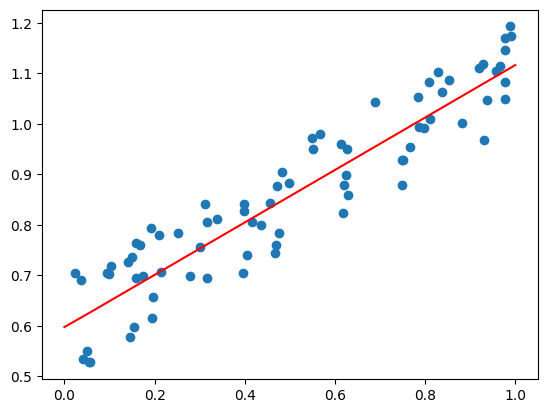

In [35]:
plt.plot(linespace, np.asarray(out), color="red")
plt.scatter(x, y)

## 分类任务

分类任务想必都不陌生，输出逻辑值，过 softmax 得到每一个类别的预测概率。

$
o_i = \frac{e^{x_i}}{\sum_s e^s}, 
\frac{\partial o_k}{\partial x_j}=
\left\{
\begin{matrix}
o_j (1-o_j),& k = j \\
-o_j o_k, & k\neq j\\
\end{matrix}
\right.
$

整理一下：

$$
\mathbf{J}=
\begin{bmatrix}
\frac{\partial o_1}{\partial x_1} & \cdots & \frac{\partial o_n}{\partial x_1} \\
\vdots & \ddots & \vdots \\
\frac{\partial o_1}{\partial x_n} & \cdots & \frac{\partial o_n}{\partial x_n} \\
\end{bmatrix}
= 
\begin{bmatrix}
o_1(1-o_1) & \cdots & -o_1 o_n \\
\vdots & \ddots & \vdots \\
-o_n o_1 & \cdots & o_n(1 - o_n) \\
\end{bmatrix}
\\
=
\begin{bmatrix}
 o_1 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & o_n \\
\end{bmatrix}
-
\begin{bmatrix}
o_1 o_1 & \cdots & o_1 o_n \\
\vdots & \ddots & \vdots \\
o_n o_1 & \cdots & o_n o_n \\
\end{bmatrix}
=
diag(\mathbf{o}) - \mathbf{o}\mathbf{o}^\top
$$

虽然我们输入的是一个 batch 的样本，但是由于上面的计算样本之间没有交互，想办法转换为 batch matmul，但是 numpy 好像不支持啊，下面给出有一个简单的循环实现。

In [36]:
class SoftMaxFunc(GradFunction):
    def forward(self, input_logits):
        # input_logits: [b, c]
        input_logits = np.asarray(input_logits)
        input_logits = input_logits - np.max(input_logits, axis=1, keepdims=True)  # 防止上溢，结果不变
        exp_out = np.exp(input_logits)
        sum_exp = np.sum(exp_out, axis=1, keepdims=True)
        softmax_out = exp_out / sum_exp
        self.ctx = (softmax_out, )
        return softmax_out
    
    def backward(self, grad_input):
        softmax_out, = self.ctx
        b, c = softmax_out.shape
        grad_out = []
        for i in range(b):
            # [c, 1]
            cur_o = np.transpose(softmax_out[i:i+1, :])
            cur_g = np.transpose(grad_input[i:i+1, :])
            diag_o = np.diag(cur_o[:, 0])
            J = diag_o - cur_o @ np.transpose(cur_o)
            cur_out_g = J @ cur_g
            
            # append [1, c]
            grad_out.append(np.transpose(cur_g))
            
        grad_out = np.concatenate(grad_out, axis=0)
        return grad_out


class SoftMax(Module):
    def forward(self, input_logits):
        return SoftMaxFunc.apply(input_logits)
    

class CrossEntropyLossFunc(GradFunction):
    def forward(self, probs, target):
        # probs: [b, c], target: [b,]
        probs = np.asarray(probs)
        b, c = probs.shape
        b_idx = np.arange(b)
        # [b]
        geted_probs = probs[b_idx, target]
        # [1]
        output = np.sum(-np.log(geted_probs + 1e-6), axis=0, keepdims=True) / b
        self.ctx = (b, c, geted_probs, b_idx, target)
        return output
    
    def backward(self, grad_input):
        # grad_input: [1] or [1, 1]
        b, c, geted_probs, b_idx, target = self.ctx
        grad_out = np.zeros((b, c))
        grad_out[b_idx, target] = - 1 / geted_probs
        return grad_out * grad_input
    
class CrossEntropy(Module):
    def forward(self, input_probs, target):
        return CrossEntropyLossFunc.apply(input_probs, target)

构建一个简单的数据集

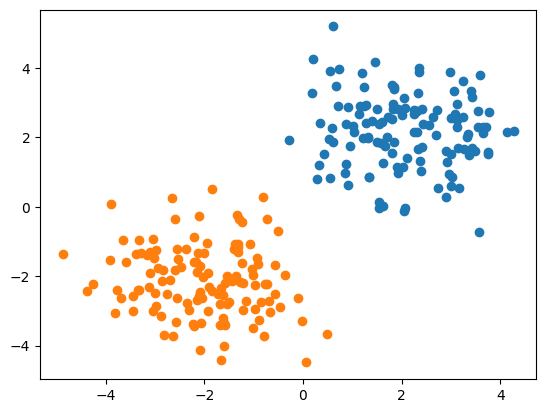

In [37]:
total_samples = 250

dist = 2
num_class_1 = int(total_samples / 2)
num_class_2 = total_samples - num_class_1
x_1 = np.random.randn(num_class_1, 2) + dist
y_1 = np.zeros(num_class_1, dtype=np.int32)
x_2 = np.random.randn(num_class_2, 2) - dist
y_2 = np.ones(num_class_2, dtype=np.int32)
plt.scatter(x_1[:, 0], x_1[:, 1])
plt.scatter(x_2[:, 0], x_2[:, 1])
# [total_samples, 2]
x = np.concatenate((x_1, x_2), axis=0)
# [total_samples,]
y = np.concatenate((y_1, y_2), axis=0)

In [38]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
classifier = MLP(2, 2)
sgd = SGD(classifier.param_list, 1e-5)

In [40]:
from tqdm import tqdm

total_iter = 1000
bs = 64
softmax = SoftMax()
ce = CrossEntropy()
classifier.requires_grad(True)
for iter in tqdm(range(total_iter)):
    index = np.random.randint(0, total_samples, bs)
    in_data = x[index, :]
    target = y[index]
    logits = classifier(in_data)
    probs = softmax(logits)
    loss = ce(probs, target)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1250.45it/s]


In [41]:
import einops
tmp_x = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(tmp_x, tmp_x)
data = np.concatenate((X[:,:, np.newaxis], Y[:,:, np.newaxis]), axis=2)
h, w, c = data.shape
data = einops.rearrange(data, "h w d -> (h w) d")
classifier.requires_grad(False)
output = classifier(data)
predict = softmax(output)
score = predict[:, 1] - predict[:, 0]
Z = einops.rearrange(score, "(h w) -> h w", h=h)

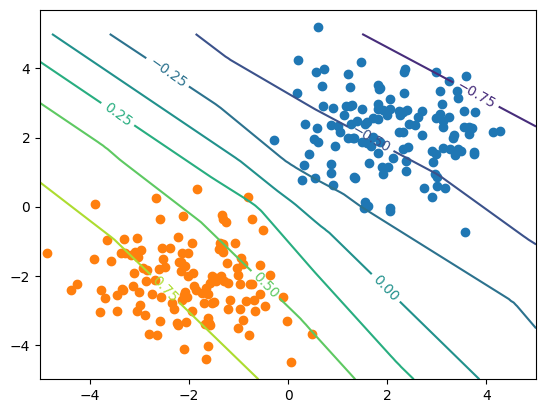

In [42]:
C = plt.contour(X,Y,Z,8)
plt.clabel(C,inline = True,fontsize = 10)
plt.scatter(x_1[:, 0], x_1[:, 1])
plt.scatter(x_2[:, 0], x_2[:, 1])

上图中 0.0 的分界线为 分类边界线